# Porto Seguro’s Safe Driver Prediction

In this competition we are tasked with making predictive models that can predict if a given driver will make insurance claim.

# Import library

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import KFold,cross_val_score,train_test_split,StratifiedKFold


from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time
seed=2123
%matplotlib inline

## Read data set

In [5]:
train = pd.read_csv('train.csv',na_values=-1)
test = pd.read_csv('test.csv',na_values=-1)
print('Number of rows and columns in train data set',train.shape)
print('Number of rows and columns in test data set',test.shape)

Number of rows and columns in train data set (595212, 59)
Number of rows and columns in test data set (892816, 58)


## check missing value

In [6]:
print('Any missing value in train data set',train.isnull().any().any())
print('Any mssing value in test data set',test.isnull().any().any())

Any missing value in train data set True
Any mssing value in test data set True


## Descriptive statistics

In [7]:
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,594996.000000,595212.000000,595129.000000,589403.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.359799,4.423318,0.416992,0.419038,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.663193,2.699902,0.493062,1.350023,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Corelation plot

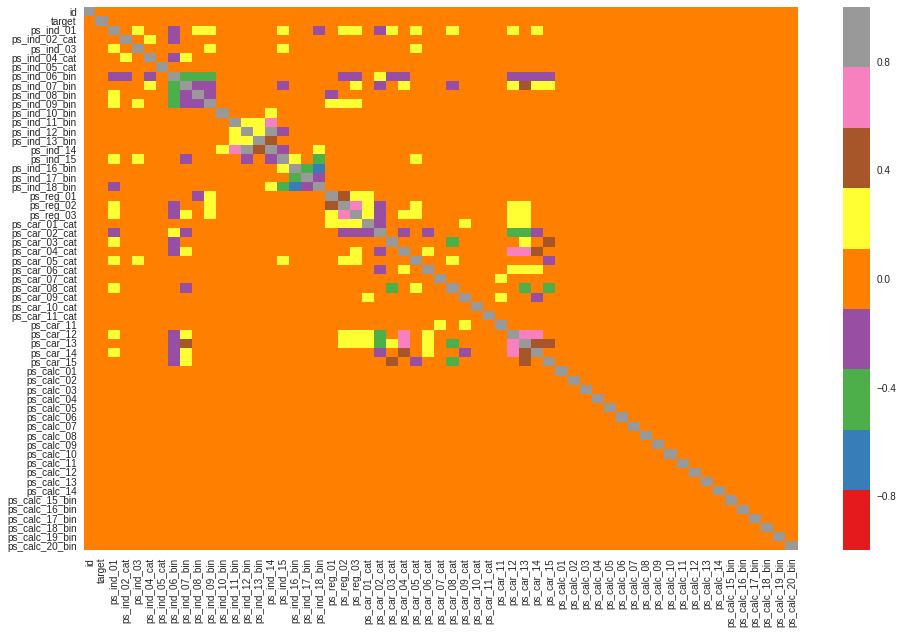

In [8]:
cor =train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor,cmap='Set1')

In [9]:
col_pscalc = list(train.columns[train.columns.str.startswith('ps_calc')])
train = train.drop(col_pscalc,axis=1)
test = test.drop(col_pscalc,axis=1)

## Get missing value feature

In [10]:
def get_missing_features(df):
    missings = pd.DataFrame([], columns=['feature', 'no_recoreds', 'percentage'])
    total_rows = df.shape[0]
    index = 0
    for feature in list(df):
        total_nulls = df[feature].isnull().sum()
        if total_nulls > 0:
            missings_perc = total_nulls / total_rows
            missings.loc[index] = [feature, total_nulls, missings_perc]
            index += 1
    missings = missings.sort_values('no_recoreds', ascending=False)
    return missings

In [11]:
get_missing_features(train)

,feature,no_recoreds,percentage
6,ps_car_03_cat,411231,0.690898
7,ps_car_05_cat,266551,0.447825
3,ps_reg_03,107772,0.181065
12,ps_car_14,42620,0.071605
8,ps_car_07_cat,11489,0.019302
2,ps_ind_05_cat,5809,0.009760
9,ps_car_09_cat,569,0.000956
0,ps_ind_02_cat,216,0.000363
4,ps_car_01_cat,107,0.000180
1,ps_ind_04_cat,83,0.000139


In [12]:
def missing_value(df):
    col = df.columns
    for i in col:
        if df[i].isnull().sum()>0:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [13]:
missing_value(train)
missing_value(test)

## Gini

In [58]:
def eval_gini(y_true,y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue,gini,delta =0,0,0
    n = len(y_true)
    for i in range(n-1,-1,-1):
        y_i = y_true[i]
        ntrue += y_i
        gini +=y_i*delta
        delta +=1-y_i
        
    gini = 1-2*gini / (ntrue * (n - ntrue))
    return gini

def gini_xgb(preds,dtrain):
    labels =dtrain.get_label
    gini_score = -eval_gini(labels,preds)
    return [('gini',gini_score)]
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

## Ensemble

In [59]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models
    
    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
    
        fold = list(StratifiedKFold(n_splits=self.n_splits,random_state=seed,shuffle=True).split(X,y))

        S_train = np.zeros((X.shape[0],len(self.base_models)))
        S_test = np.zeros((T.shape[0],len(self.base_models)))

        for i,clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0],self.n_splits))

            for j, (train_index,valid_index) in enumerate(fold):
                Xtrain, Xvalid = X[train_index], X[valid_index]
                ytrain, yvalid = y[train_index], y[valid_index]

                clf.fit(Xtrain, ytrain)
                valid_pred = clf.predict_proba(Xvalid)[:,1]            
                S_train[valid_index,i] = valid_pred
                S_test_i[:,j] = clf.predict_proba(T)[:,1]

            print('\n Training Gini for model {} : {}'.format(i,eval_gini(y,S_train[:,i])))
            S_test[:,i] = S_test_i.mean(axis=1)

        return S_train, S_test

## Ligthgbm model

In [76]:
# LightGBM params
lgb_params = {}
lgb_params['learning_rate'] = 0.02
lgb_params['n_estimators'] = 700
lgb_params['max_bin'] = 15
lgb_params['subsample'] = 0.8
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.8   
lgb_params['min_child_samples'] = 800
lgb_params['seed'] = seed
lgb_params['scale_pos_weight'] = 3
lgb_params['silent'] =True 

lgb_params2 = {}
lgb_params2['learning_rate'] = 0.02
lgb_params2['n_estimators'] = 900
lgb_params2['max_bin'] = 20
lgb_params2['subsample'] = 0.8
lgb_params2['subsample_freq'] = 10
lgb_params2['colsample_bytree'] = 0.8   
lgb_params2['min_child_samples'] = 600
lgb_params2['seed'] = seed
lgb_params2['scale_pos_weight'] = 3
lgb_params2['silent'] =True 

lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 99

lgb_model = LGBMClassifier(**lgb_params)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)

In [77]:
lgb_stack = Create_ensemble(n_splits=5,base_models=[lgb_model,lgb_model2,lgb_model3])
X = train.drop(['id','target'],axis=1)
y= train['target'].values
T = test.drop(['id'],axis=1)
lgb_train_pred, lgb_test_pred = lgb_stack.predict(X,y,T)


 Training Gini for model 0 : 0.2841816719604151

 Training Gini for model 1 : 0.2836010527386762

 Training Gini for model 2 : 0.2819820055816924


In [84]:
#ypred = LogisticRegression(C=1,class_weight='balanced').fit(lgb_train_pred,y).predict_proba(lgb_test_pred)[:,1]
ypred = RandomForestClassifier(n_estimators=200,max_depth=12,random_state=seed).fit(lgb_train_pred,y).predict_proba(lgb_test_pred)[:,1]

## Submission file

In [86]:
#ypred = lgb_test_pred.mean(axis=1)
submit = pd.DataFrame({'id':test['id'],'target':ypred})
submit.to_csv('stack_porto.csv.gz',index=False,compression='gzip')

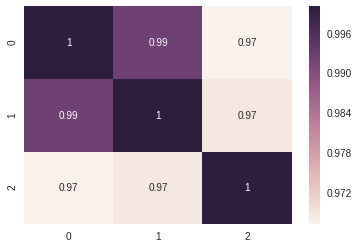

In [80]:
cor = pd.DataFrame(lgb_test_pred).corr()
sns.heatmap(cor,annot=True)

# Thanks